In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset



%matplotlib widget
%load_ext autoreload
%autoreload 2
from stressgait_analysis.gait_helper_functions import (compute_HS)
import numpy as np

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait = {
    "omc": omc_color,
    "control": controls_color
}

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

In [4]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)

In [5]:
kinematics = dataset.kinematics.droplevel(level="bout")
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q#.head()

hip_flexion  knee_flexion  \
participant condition speed percentage_of_stride                              
VP_01       omc       fast  0                       16.672305     -1.643508   
                            1                       16.742015     -1.106875   
                            2                       16.800376     -0.381644   
                            3                       16.813459      0.991988   
                            4                       16.754319      2.397110   
...                                                       ...           ...   
VP_47       omc       slow  96                      19.038657     18.334700   
                            97                      18.706096     15.990487   
                            98                      18.331759     14.138599   
                            99                      17.919661     12.764022   
                            100                     17.486822     11.682882   

                                                  elbow_angle  shoulder_angle  \
participant condition speed percentage_of_stride                                
VP_01       omc       fast  0                      173.363706      167.973590   
                            1                      173.726198      167.528950   
                            2                      174.109902      167.115063   
                            3                      174.568835      166.810044   
                            4                      175.053780      166.570782   
...                                                       ...             ...   
VP_47       omc       slow  96                     155.361844      174.845928   
                            97                     155.642629      174.537190   
                            98                     155.875403      174.290817   
                            99                     156.077381      174.101675   
                            100                    156.260951      173.946175   

                                                  arm_swing  
participant condition speed percentage_of_stride             
VP_01       omc       fast  0                    -41.723325  
                            1                    -43.326227  
                            2                    -44.823183  
                            3                    -45.944825  
                            4                    -46.840332  
...                                                     ...  
VP_47       omc       slow  96                   -14.805439  
                            97                   -15.958069  
                            98                   -16.845512  
                            99                   -17.519930  
                            100                  -18.067868  

[8080 rows x 5 columns]

split into omc / control as well as fast / slow

In [6]:
omc_kinematics_slow = cycle_averaged_q.xs(("omc", "slow"), level=("condition", "speed"))
omc_kinematics_fast = cycle_averaged_q.xs(("omc", "fast"), level=("condition", "speed"))

control_kinematics_slow = cycle_averaged_q.xs(("control", "slow"), level=("condition", "speed"))
control_kinematics_fast = cycle_averaged_q.xs(("control", "fast"), level=("condition", "speed"))

for spm, we need data in the format J x Q, where J are the participants per group and Q are the nodes

In [7]:
omc_slow_hip = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_slow_knee = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

control_slow_hip = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_slow_knee = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

omc_fast_hip = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_fast_knee = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

control_fast_hip = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_fast_knee = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")


In [10]:
def plot_result(YA, YB, ti, ylabel=None):
    sns.set_style("white")
### plot mean and SD:
    fig = plt.figure( figsize=(8, 3.5) )
    ax     = plt.axes( (0.1, 0.15, 0.35, 0.8) )
    spm1d.plot.plot_mean_sd(YA, linecolor=stressgait["omc"],label="OMC", facecolor=stressgait["omc"], ax=ax)
    spm1d.plot.plot_mean_sd(YB,  linecolor=stressgait["control"], label= "Control", facecolor=stressgait["control"], ax=ax)

    ax.set_xlabel('% of stride', fontsize=16)
    ax.tick_params(axis='both',labelsize=12)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', colors='black', labelsize=12, bottom=True, left=True, labelbottom=True)
    plt.legend()
    ### plot SPM results:
    ax= plt.axes((0.55,0.15,0.35,0.8))

    ti.plot(facecolor="red")

    ax.set_ylabel( "SPM{t}",fontsize=16)
   # ti.plot_threshold_label(fontsize=8)
    alpha = 0.0125
    tstar = ti.zstar  # or use the threshold value directly

# Optional: plot the threshold line manually if not already present
#    plt.axhline(y=tstar, linestyle='--', color='k')

# Add your custom label
    plt.text(
    x=60,       # e.g. 5 or plt.xlim()[0] + some_offset
    y=tstar + 0.1,           # position slightly above the line
    s=f"α = {alpha:.4f}, t* = {tstar:.3f}",
    fontsize=12,
    color='red',
    ha='center'
)
    ti.plot_p_values(size=14, offsets=[(30,0.5)])
    ax.set_xlabel('% of stride', fontsize=16)
    ax.tick_params(axis='both', colors='black', labelsize=12, left=True, bottom=True, labelbottom=True)

    return fig

## SPM for the hip

### slow

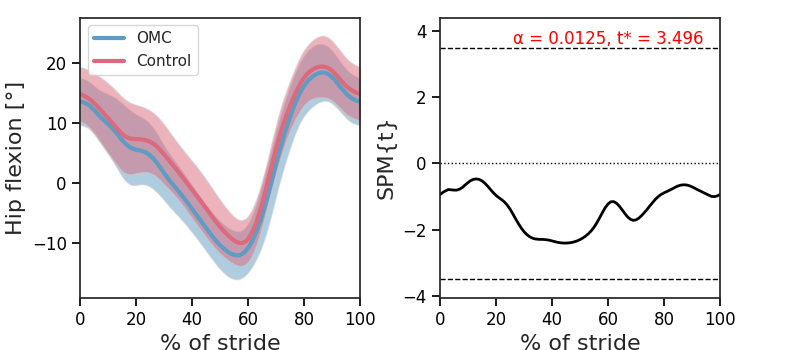

In [12]:
t = spm1d.stats.ttest2(np.array(omc_slow_hip), np.array(control_slow_hip))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_slow_hip, control_slow_hip, ti, "Hip flexion [°]")
plt.savefig("../../exports/spm_hip_slow.pdf")

### fast

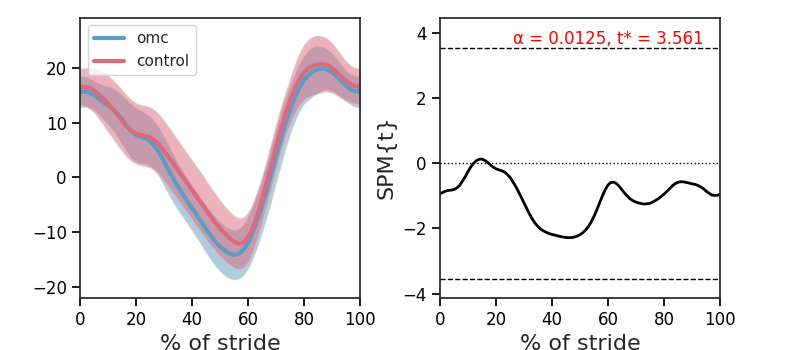

In [52]:
t = spm1d.stats.ttest2(np.array(omc_fast_hip), np.array(control_fast_hip))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_fast_hip, control_fast_hip, ti)

## knee

### slow

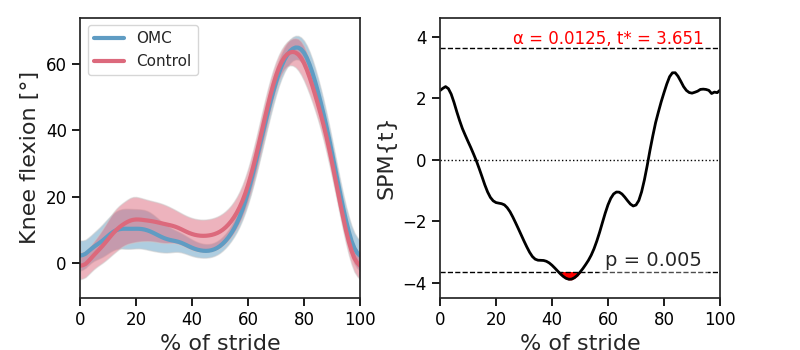

In [13]:
t = spm1d.stats.ttest2(np.array(omc_slow_knee), np.array(control_slow_knee))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_slow_knee, control_slow_knee, ti, "Knee flexion [°]")
plt.savefig("../../exports/spm_knee_slow.pdf")

In [13]:
ti.clusters

[Cluster
    threshold       :  -3.651
    centroid        :  (46.052, -3.776)
    isinterpolated  :  True
    iswrapped       :  False
    endpoints       :  (42.430, 49.983)
    extent          :  7.553
    extent (resels) :  0.41704
    height (min)    :  3.65145
    P               :  0.00498
 ]

### fast

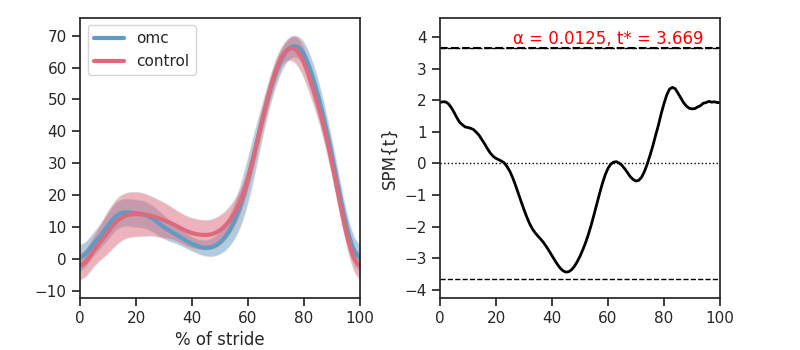

In [14]:
t = spm1d.stats.ttest2(np.array(omc_fast_knee), np.array(control_fast_knee))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_fast_knee, control_fast_knee, ti)

In [15]:
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q.head()
c = cycle_averaged_q.reset_index()

In [16]:
responder_list = ["VP_02", "VP_05", "VP_06", "VP_15", "VP_16", "VP_17", "VP_24", "VP_35", "VP_36", "VP_43", "VP_45", "VP47"]
cycle_averaged_q["responder"] = [1 if r[1].participant in responder_list else 0 for r in c.iterrows()]
cycle_averaged_q.set_index("responder", append=True, inplace=True)

In [17]:
cycle_averaged_q

hip_flexion  \
participant condition speed percentage_of_stride responder                
VP_01       omc       fast  0                    0            16.672305   
                            1                    0            16.742015   
                            2                    0            16.800376   
                            3                    0            16.813459   
                            4                    0            16.754319   
...                                                                 ...   
VP_47       omc       slow  96                   0            19.038657   
                            97                   0            18.706096   
                            98                   0            18.331759   
                            99                   0            17.919661   
                            100                  0            17.486822   

                                                            knee_flexion  \
participant condition speed percentage_of_stride responder                 
VP_01       omc       fast  0                    0             -1.643508   
                            1                    0             -1.106875   
                            2                    0             -0.381644   
                            3                    0              0.991988   
                            4                    0              2.397110   
...                                                                  ...   
VP_47       omc       slow  96                   0             18.334700   
                            97                   0             15.990487   
                            98                   0             14.138599   
                            99                   0             12.764022   
                            100                  0             11.682882   

                                                            elbow_angle  \
participant condition speed percentage_of_stride responder                
VP_01       omc       fast  0                    0           173.363706   
                            1                    0           173.726198   
                            2                    0           174.109902   
                            3                    0           174.568835   
                            4                    0           175.053780   
...                                                                 ...   
VP_47       omc       slow  96                   0           155.361844   
                            97                   0           155.642629   
                            98                   0           155.875403   
                            99                   0           156.077381   
                            100                  0           156.260951   

                                                            shoulder_angle  \
participant condition speed percentage_of_stride responder                   
VP_01       omc       fast  0                    0              167.973590   
                            1                    0              167.528950   
                            2                    0              167.115063   
                            3                    0              166.810044   
                            4                    0              166.570782   
...                                                                    ...   
VP_47       omc       slow  96                   0              174.845928   
                            97                   0              174.537190   
                            98                   0              174.290817   
                            99                   0              174.101675   
                            100                  0              173.946175   

                                                            arm_swing  
participant condition speed perc

In [18]:
kin_responder = cycle_averaged_q.xs((1, "slow"), level=("responder", "speed"))
kin_non_responder= cycle_averaged_q.xs((0, "slow"), level=("responder", "speed"))